<a href="https://colab.research.google.com/github/VRehnberg/pairwise_modularity/blob/main/pairwise_similarity_modularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# Basic utilities
import os
import gc
import urllib
import warnings
from math import pi
from functools import partial
from tqdm.auto import tqdm

# Numerics
import numpy as np
from sklearn.cluster import SpectralClustering

# Machine learning
import torch
from torch import nn, optim
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
sns.set_style("ticks")


## Load MNIST

In [2]:
batch_size = 1024
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10


## Generator
Using a [pretrained](https://colab.research.google.com/drive/12lFAHpVIVOHK8dVbZOlVxnMhFlfKnMND) Generator for MNIST data.

The Generators input distribution is a 100-dimensional multivariate standard normal. The gradient of a multivariate normal with covariance matrix $\Sigma = \mathrm{I}$ and zero mean is
$$\begin{aligned}
  \nabla f(\vec{x}) &= \vec{x}f(\vec{x})\,, \\
  f(\vec{x}) &= \left(\frac{1}{2\pi}\right)^{\mathrm{dim}(\vec{x})} \mathrm{e}^{-\frac{1}{2}\vec{x}^\mathsf{T}\vec{x}} 
\end{aligned}$$

In [3]:
class GeneratorInput():

    def sample(self, batch_size):
        '''Samples Generator input distribution.'''
        x_in = torch.randn(
            batch_size, 100,
            device=device,
            requires_grad=True,
        )
        return x_in

    def gradient(self, x_in, normalized=False):
        '''Computes the gradient of x_in.'''
        x_in_squared = torch.einsum("b...,b...->b", x_in, x_in).unsqueeze(1)
        grad = x_in * torch.exp(-0.5 * x_in_squared)
        if normalized:
            grad *= (2 * pi) ** x_in.shape[1]
        return grad


class GeneratorNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )
        self.input = GeneratorInput()

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], 28, 28)
        return img

    def generate(self, batch_size):
        '''Generates samples from MNIST input manifold.'''
        x_in = self.input.sample(batch_size)
        x_out = self(x_in)
        return x_out

generator = GeneratorNetwork()
generator.to(device)

if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve("https://github.com/VRehnberg/AISC5-ID/raw/master/mnist_generator.pth", "./pretrained/mnist_generator.pth")
generator.load_state_dict(torch.load('./pretrained/mnist_generator.pth', map_location=device))
print('done')


downloading ...
done


## Architecture

In [4]:
class MLP(nn.Module):
    def __init__(self, layers, Activation=nn.ReLU):
        super().__init__()
        self.input_shape = layers[0]
        hidden = [
            layer
            for li, lo in zip(layers, layers[1:])
            for layer in [nn.Linear(li, lo), Activation()]
        ][:-1]
        self.hidden = nn.ModuleList(hidden)

    def forward(self, x):
        x = x.view(-1, self.input_shape)
        for layer in self.hidden:
            x = layer(x)
        return x


## Network utilities

In [5]:
def get_activations(network, x):
    activations = []
    hooks = []
    for name, m in network.named_modules():
        if isinstance(m, nn.Linear):
            save_activations = lambda mod, inp, out: activations.append(out)
            hooks.append(m.register_forward_hook(save_activations))
    
    network(x)
    for h in hooks:
        h.remove()
    
    return torch.hstack(activations)


def batched_jacobian(func, x, to_embedding=False, **kwargs):

    # Copmute batched Jacobian
    new_func = lambda x: func(x).sum(0)
    jac = jacobian(new_func, x, **kwargs)
    
    if to_embedding:
        # Create embedding of shape (func(x[0]).nelement(), x.nelement())
        jac = jac.flatten(-x.ndim).flatten(end_dim=-2)
    else:
        # Move batch dimension first
        dims = torch.arange(jac.ndim, device=device)
        batch_dim = dims[-x.ndim]
        jac.movedims(dims[:batch_dim + 1], [batch_dim, *dims[:batch_dim]])

    return jac


def clean_mem():
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()


## Pairwise similarities loss term

In [6]:
def jacobian_correlation_adjacency(jac):
    assert jac.ndim == 2
    jac = jac - jac.mean()
    jac = jac / jac.abs().mean()  # for numerical stability
    assert not torch.isnan(jac).any(), "NaN found in Jacobian."
    cov = jac @ jac.T
    assert not torch.isnan(cov).any(), "NaN found in covariance matrix."
    inv_std = 1 / cov.diag().sqrt()
    corr = cov * inv_std * inv_std.unsqueeze(1)
    adj_mat = corr ** 2
    assert not torch.isnan(adj_mat).any(), "NaN found in adjacency matrix."
    return adj_mat


def compute_adjacency_matrix(
    network,
    x,
    mode="jacobian",
    use_generator=False,
    generator=generator,
    create_graph=False,
):
    if mode=="jacobian" and use_generator:
        #x_in = generator.input.sample(generator_batch_size)
        #generator_jac, x_out = batched_jacobian(
        #    generator,
        #    x_in,
        #    return_output=True,
        #    newdim=1,
        #)
        #generator_jac *= generator.input.gradient(x_in).unsqueeze(0)
        #
        #activations_jac = batched_jacobian(
        #    partial(get_activations, network),
        #    x_out,
        #    newdim=1,
        #)
        #jac = torch.einsum('ibj,jbk->ibk', activations_jac, generator_jac)
        #jac = jac.flatten(1)
        raise NotImplementedError()
    
    elif mode=="jacobian" and not use_generator:
        # Compute jacobian
        func = partial(get_activations, network)
        jac = batched_jacobian(
            func,
            x,
            to_embedding=True,
            create_graph=create_graph,
        )

        # Adjacency matrix from jacobian
        adj_mat = jacobian_correlation_adjacency(jac)
        
    elif mode=="coactivation":
        raise NotImplementedError()
    
    elif mode=="mutual_information":
        raise NotImplementedError()
    
    else:
        raise ValueError(f"Mode {mode} is not valid.")

    return adj_mat


def compute_laplacian(adj_mat):
    '''Computes normalized Laplacian from embedding.
    
    Parameters:
        embedding (Tensor): n_neurons × n_features
    
    Returns:
        lap (Tensor): n_neurons × n_neurons
    '''
    # Compute normalized laplacian
    inv_sqrt_degree = 1 / adj_mat.sum(0, keepdims=True).sqrt()
    adjnorm = adj_mat * inv_sqrt_degree * inv_sqrt_degree.T
    lap = torch.eye(adjnorm.shape[0]).to(device) - adjnorm

    return lap


class PairwiseSimilarityLoss(nn.modules.loss._Loss):

    __constants__ = ["reduction"]

    def __init__(
        self,
        mode="jacobian",
        use_generator=True,
        generator=None,
        size_average=None,
        reduce=None,
        reduction='mean',
    ):
        super().__init__(size_average, reduce, reduction)
        self.adjacency = partial(
            compute_adjacency_matrix, 
            mode="jacobian",
            use_generator=False,
            generator=generator,
            create_graph=True,
        )

    def forward(self, network, x, n_clusters):
        # Compute adjacency matrix
        adj_mat = self.adjacency(network, x)
        assert torch.allclose(adj_mat, adj_mat.T), "Adjacency matrix not symmetric."

        # Compute normalized laplacian
        lap = compute_laplacian(adj_mat)
        assert torch.allclose(lap, lap.T), "Laplacian not symmetric."
    
        # Compute eigenvalues
        eigval, eigvec = torch.symeig(lap, eigenvectors=True)
        assert torch.allclose(eigval, eigval.sort(descending=False)[0]), "Eigenvalues not in ascending order."
        if (torch.diff(eigval[:n_clusters + 2]) < 1e-5).any():
            warnings.warn("Non-distinct eigenvalues. Backwards call might be unstable.")
        
        # Regularisation term
        loss = eigval[n_clusters]
    
        return loss


## Training

In [7]:
%%time
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
mlp = MLP(layers).to(device)

# Regularisation param
act_reg = 1.0
n_clusters = 3

# Optimisation param
n_epochs = 10
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

# Losses
pairwise_loss_function = PairwiseSimilarityLoss(
    mode="jacobian",
    use_generator=False,
)
loss_function = nn.CrossEntropyLoss()

#Train
n_batches = len(train_dataloader)
pbar = tqdm(desc="Train", total=(n_epochs * n_batches))
for epoch in range(n_epochs):

    batch_loss = 0.0
    batch_actloss = 0.0
    batch_acc = 0.0
    
    for i_batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        mlp.train()
        optimizer.zero_grad()

        y_estimate = mlp(x)

        # Usual loss
        loss = loss_function(y_estimate, y)
        batch_loss += loss.detach().cpu()
        
        # Accuracy
        batch_acc += (torch.argmax(y_estimate, dim=1) == y).float().mean().detach().cpu()

        # Activation regularisation
        if act_reg:
            actloss = act_reg * pairwise_loss_function(mlp, x, n_clusters)

            batch_actloss += actloss.detach().cpu()
            actloss.backward()

        pbar.update(1)

        # Retain graph to be able to reuse generator input in backward 
        loss.backward()
        optimizer.step()

    # Print metrics for this epoch
    avg_acc = batch_acc / n_batches
    avg_loss = batch_loss / n_batches
    avg_actloss = batch_actloss / n_batches
    al_str = f', AL: {avg_actloss:.4f}' if act_reg else ''
    pbar.write(f'Epoch {epoch}. Acc {avg_acc:.4f}, CE: {avg_loss:.4f}{al_str}')

    clean_mem()


Epoch 0. Acc 0.7203, CE: 0.8535, AL: 0.3096
Epoch 1. Acc 0.9142, CE: 0.2826, AL: 0.0833
Epoch 2. Acc 0.9366, CE: 0.2086, AL: 0.0451
Epoch 3. Acc 0.9411, CE: 0.1930, AL: 0.0380
Epoch 4. Acc 0.9498, CE: 0.1650, AL: 0.0343
Epoch 5. Acc 0.9543, CE: 0.1494, AL: 0.0321
Epoch 6. Acc 0.9596, CE: 0.1343, AL: 0.0270
Epoch 7. Acc 0.9611, CE: 0.1285, AL: 0.0238
Epoch 8. Acc 0.9615, CE: 0.1259, AL: 0.0238
Epoch 9. Acc 0.9631, CE: 0.1187, AL: 0.0246
CPU times: user 3min 2s, sys: 33.5 s, total: 3min 36s
Wall time: 3min 38s


## Different clusterings

In [8]:
clusters = {}

# Layer labels for neurons
# NB this assumes that named modules appear in order of their execution
i_layer = []
layer_counter = 1
for name, mod in mlp.named_modules():
    if isinstance(mod, nn.Linear):
        n_neurons = mod.out_features
        i_layer.extend(n_neurons * [layer_counter])
        layer_counter += 1
i_layer = np.array(i_layer)
clusters["Layer"] = i_layer

# Adjacency based clustering
mlp.eval()
n_activations = 120
n_batches = len(test_dataset)
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters,
    affinity="precomputed",
    n_init=100,
    assign_labels="discretize",
)
adjacency_matrices = {}
for name, adj_kwargs in [
    ("Jacobian", dict(mode="jacobian", use_generator=False))
    #("", dict(mode="jacobian", use_generator=True))
    #("", dict(mode="coactivation"))
    #("", dict(mode="mutual_information"))
]:
    adj_mat = torch.zeros([120, 120], device=device)
    for x, y in test_dataloader:
        x = x.to(device)
        adj_mat += compute_adjacency_matrix(mlp, x, **adj_kwargs)
    
    # This is only an approximation of the true adjacency matrix
    adj_mat /= n_batches
    adj_mat = adj_mat.detach().cpu().numpy()

    adjacency_matrices[name] = adj_mat

    # Cluster into modules
    i_clusters = spectral_clustering.fit_predict(adj_mat)

    clusters[name] = i_clusters

# Randomly assign neurons to clusters
clusters["Random"] = np.random.randint(0, n_clusters, n_activations)

## Visualise adjacency matrices

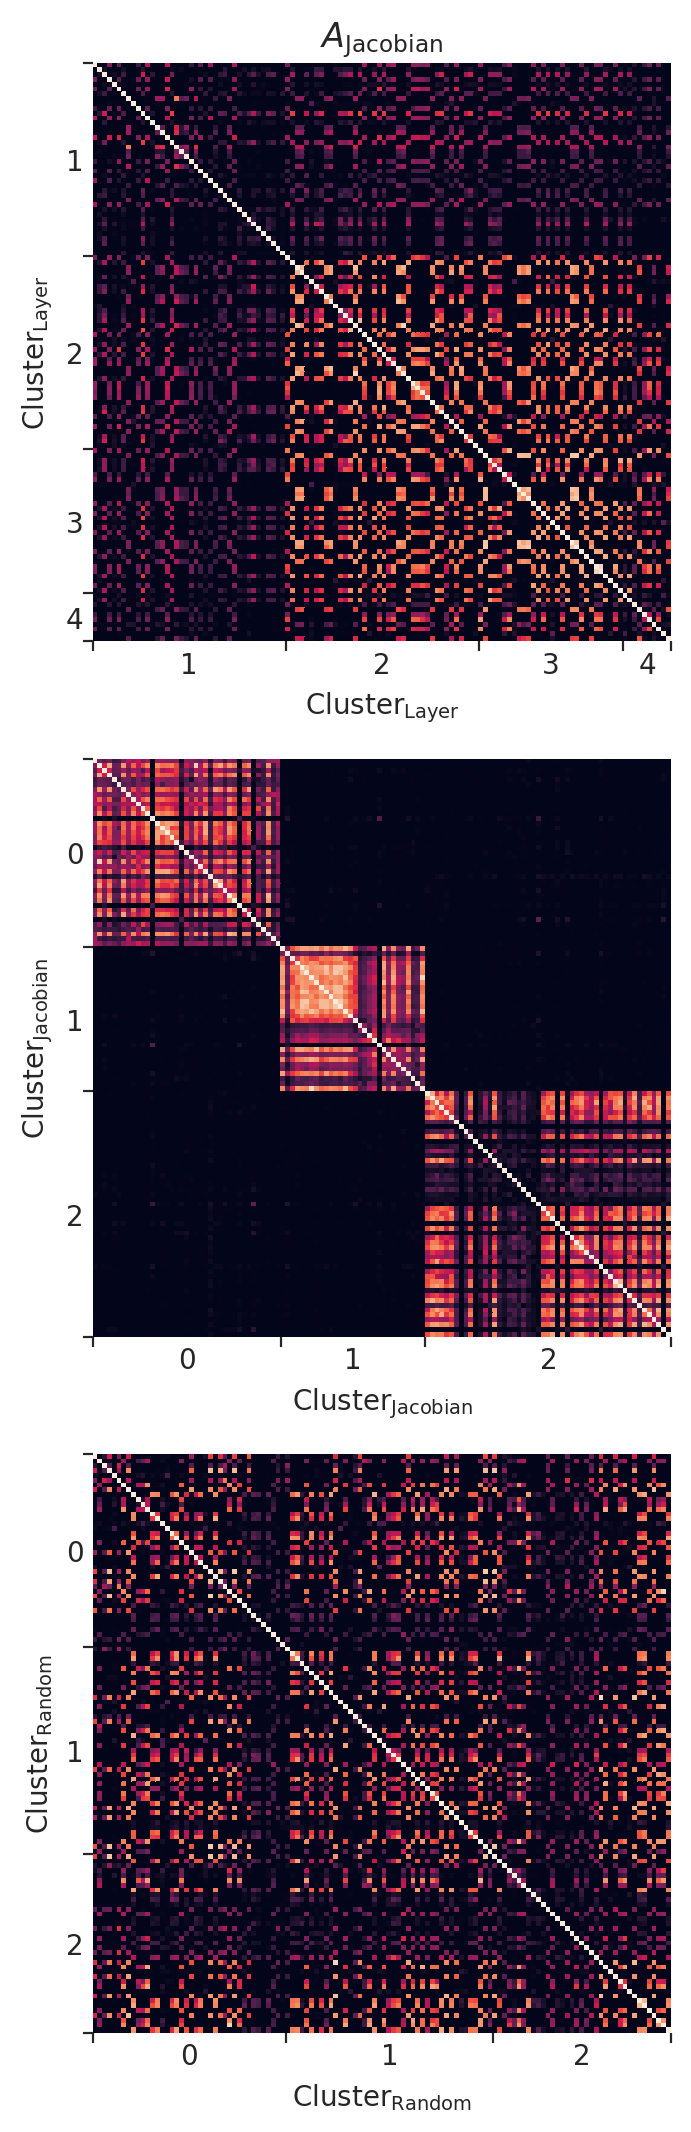

In [14]:
n_rows = len(clusters)
n_cols = len(adjacency_matrices)
fig, axs = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4.8 * n_cols, 3.6 * n_rows),
    dpi=100,
)
axs = axs.reshape(n_rows, n_cols)
for i_row, (cluster_name, i_cluster) in enumerate(clusters.items()):
    for i_col, (adj_mat_name, adj_mat) in enumerate(adjacency_matrices.items()):
        ax = axs[i_row, i_col]

        # Sort adjacency matrix
        i_sort = np.argsort(i_cluster)
        adj_mat = adj_mat[i_sort, :][:, i_sort]

        # Heatmap
        sns.heatmap(adj_mat, ax=ax, square=True, cbar=False)
        
        # Set column title
        if i_row==0:
            ax.set_title(r"$A_\mathrm{" + adj_mat_name + "}$")

        # Set cluster name
        xy_label = r"Cluster$_\mathrm{" + cluster_name + "}$"
        ax.set_ylabel(xy_label)
        ax.set_xlabel(xy_label)

        # Set ticks
        labels, counts = np.unique(i_cluster, return_counts=True)
        ticks = np.cumsum([0, *counts])
        centered_ticks = (ticks[1:] + ticks[:-1]) / 2
        ticklabels = labels
        for subax in [ax.xaxis, ax.yaxis]:
            subax.set_major_locator(ticker.FixedLocator(ticks))
            subax.set_major_formatter(ticker.NullFormatter())
            subax.set_minor_locator(ticker.FixedLocator(centered_ticks))
            subax.set_minor_formatter(ticker.FixedFormatter(ticklabels))
        ax.tick_params(which="minor", length=0.0)

fig.tight_layout()